# Mean profile based moa prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [3]:
import pyarrow

# Data

In [201]:
try:
    paths = snakemake.input.paths
    labels_path = snakemake.input.labels
except NameError:
    data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021")
    data_dir = data_root / "scip"
    paths = data_dir.rglob("features.parquet")
    labels_path = data_dir.parent / "labels.parquet"
    moa_path = data_root / "BBBC021_v1_moa.csv"

In [37]:
df = pandas.concat([pq.read_table(p).to_pandas() for p in paths])

In [56]:
df = df.drop(columns=['meta_image_metadata_compound', 'meta_image_metadata_concentration'])

In [57]:
labels = pq.read_table(labels_path).to_pandas()

In [62]:
df = df.merge(labels, left_on="meta_filename", right_on="meta_image_filename_dapi", suffixes=("_", ""), how="inner")
df = df.drop(columns=df.filter(regex="_$"))

In [63]:
df.columns[df.isna().all()]

Index([], dtype='object')

In [82]:
df = df[~df.isna().any(axis=1)]

In [231]:
moa = pandas.read_csv(moa_path).set_index(["compound", "concentration"])

# Removing interplate variation

In [116]:
qq_dmso = df[df["meta_moa"] == "DMSO"].groupby("meta_image_metadata_plate_dapi")[df.filter(regex="feat").columns].quantile((0.01, 0.99))

In [289]:
dfs = []
for idx, gdf in df[df["meta_moa"] != "DMSO"].groupby("meta_image_metadata_plate_dapi"):
    df_scaled = (gdf.filter(regex="feat") - qq_dmso.loc[idx, 0.01]) / (qq_dmso.loc[idx, 0.99] - qq_dmso.loc[idx, 0.01])
    df_scaled = pandas.concat([df_scaled, gdf.filter(regex="meta")], axis=1)
    
    dfs.append(df_scaled)

In [290]:
df_scaled = pandas.concat(dfs)

In [291]:
df_scaled.columns[df_scaled.isna().all()]

Index(['feat_euler_number_combined', 'feat_euler_number_actin',
       'feat_euler_number_tubulin'],
      dtype='object')

In [292]:
nancols = df_scaled.columns[df_scaled.isna().any()]
nancols

Index(['feat_euler_number_combined', 'feat_euler_number_DAPI',
       'feat_euler_number_actin', 'feat_euler_number_tubulin'],
      dtype='object')

In [293]:
df_scaled = df_scaled.drop(columns=nancols)

In [294]:
mu = df_scaled.groupby(["meta_compound", "meta_concentration", "meta_replicate"])[df_scaled.filter(regex="feat").columns].mean()

In [295]:
treatment_profiles = mu.groupby(["meta_compound", "meta_concentration"]).median()
treatment_profiles.index.names = ["compound", "concentration"]
treatment_profiles = treatment_profiles.merge(moa, left_index=True, right_index=True).reset_index()

# Exploration

<AxesSubplot:xlabel='count', ylabel='moa'>

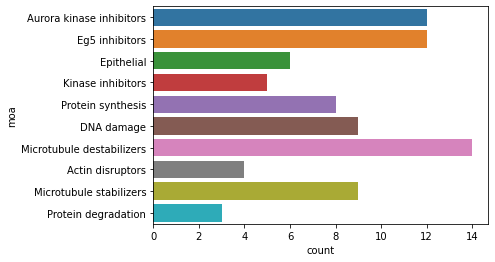

In [296]:
seaborn.countplot(data=treatment_profiles, y="moa")

<AxesSubplot:xlabel='count', ylabel='compound'>

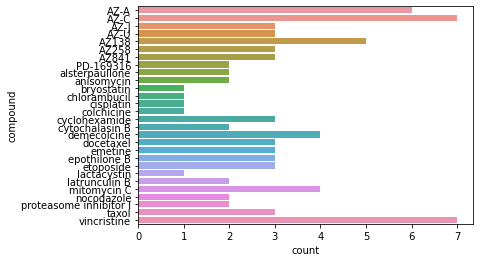

In [297]:
seaborn.countplot(data=treatment_profiles, y="compound")

## dimdred

In [298]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [299]:
dimred = PCA().fit_transform(scale(treatment_profiles.filter(regex="feat")))

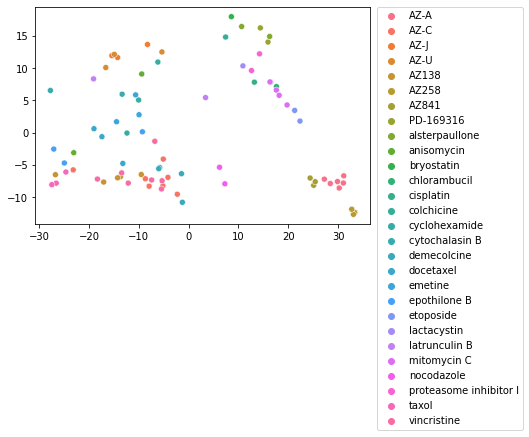

In [300]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["compound"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

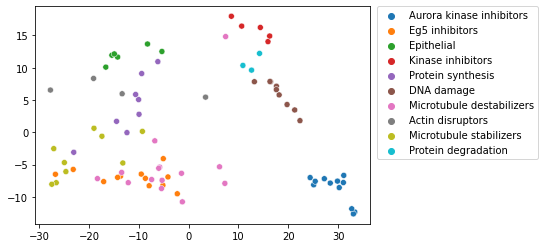

In [301]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["moa"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [302]:
from umap import UMAP

In [318]:
dimred = UMAP(metric="cosine", min_dist=0.5, n_neighbors=8, random_state=0).fit_transform(treatment_profiles.filter(regex="feat"))

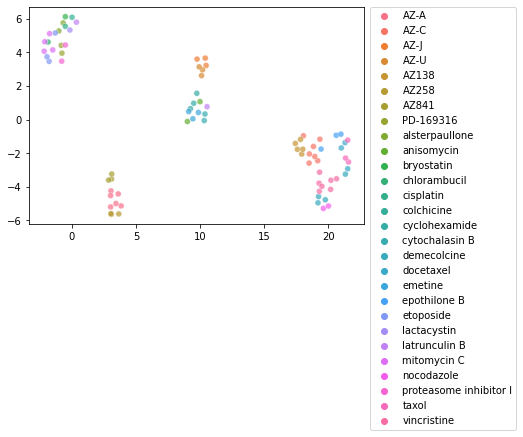

In [319]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["compound"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

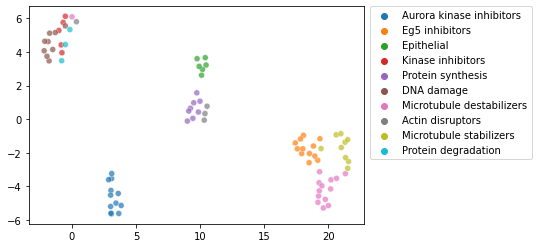

In [320]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["moa"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Prediction

In [280]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [324]:
results = cross_validate(
    cv=LeaveOneGroupOut(),
    X=treatment_profiles.filter(regex="feat"),
    y=treatment_profiles["moa"],
    groups=treatment_profiles["compound"],
    estimator=make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=1, metric="cosine"),
    ),
    return_train_score=True,
    scoring=("accuracy", "balanced_accuracy", "f1_macro", "precision_macro")
)

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc

In [325]:
results["train_accuracy"].mean(), results["train_accuracy"].std()

(1.0, 0.0)

In [326]:
results["test_accuracy"].mean(), results["test_accuracy"].std()

(0.8647959183673469, 0.3150381101213333)